In [1]:
import itertools

import numpy as np
import jax.numpy as jnp
from jax import random, jit, jacfwd, jacrev, grad, vmap
from jax.numpy.linalg import inv
from jax.nn import tanh, sigmoid, relu
from jax.experimental.ode import odeint

from scipy.optimize import minimize
from scipy.stats import norm

import matplotlib.pyplot as plt

np.random.seed(123)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-i2iy4s3e because the default path (/home/jaron/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# generate data from a ground truth ODE model (generalized Lotka-Volterra)

# number of species
n_s = 5 

# growth rates
r = np.random.uniform(.3, .5, n_s)

# interaction matrix
A = np.random.uniform(-.5, .3, size=[n_s, n_s])
for i in range(n_s):
    # self interaction is negative
    A[i, i] = -1.
    
# model parameters will be the latent variables to estimate later
z_true = jnp.append(r, A.flatten())

# function to reshape latent variables 
def reshape_z(z):
    r = z[:n_s]
    A = jnp.reshape(z[n_s:], [n_s, n_s])
    return r, A
    
# generalized Lotka Volterra model (gLV)
def gLV_gt(x, t, z):
    r, A = reshape_z(z)
    return x*(r + jnp.einsum('ij,j->i', A, x))

# full factorial  
x0s = [.1*np.reshape(np.array(i), (1, n_s)) for i in itertools.product([0, 1], repeat = n_s)]
# remove all zeros community
x0s = np.array(np.concatenate(x0s)[1:], float)

# number of measurement times
m = 5

# time frame
t_span = jnp.linspace(0, 24, m)

# measurement noise (s = standard deviation and beta = precision)
s = 0.01
beta = (1./s)**2

# integrate gLV and add noise to generate simulated data
X = []
for x0 in x0s:
    # integrate ODE
    x = odeint(gLV_gt, jnp.array(x0), t_span, z_true)
    
    # add noise after initial condition of inoculated species
    x = x.at[1:].set(x[1:] + s*np.random.randn(m-1, n_s))
    x = jnp.einsum('tk,k->tk', x, np.array(x[0]>0, int))
    
    # append to X
    X.append(x)

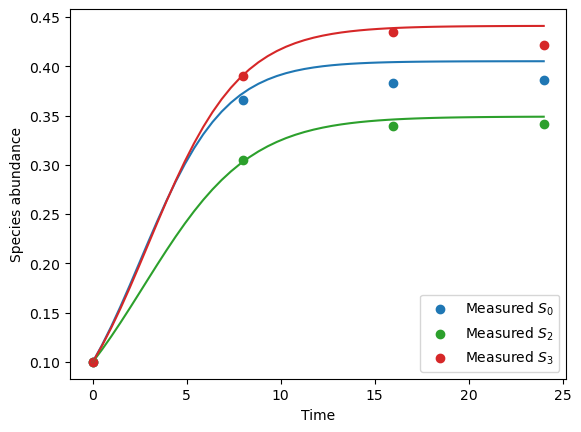

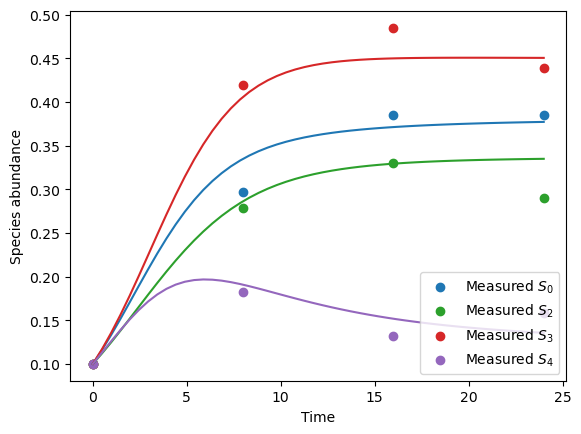

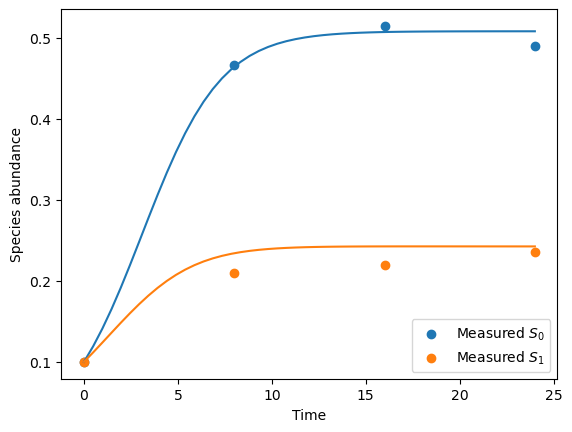

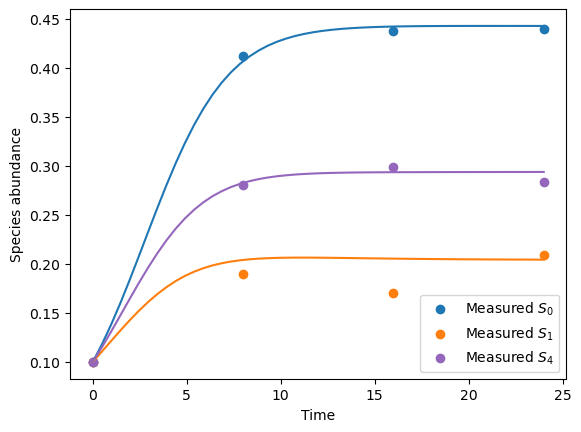

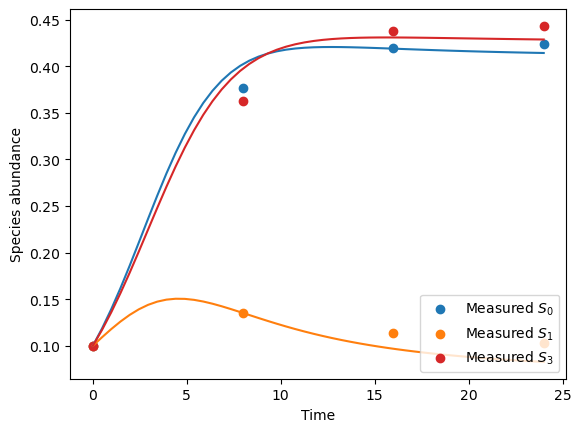

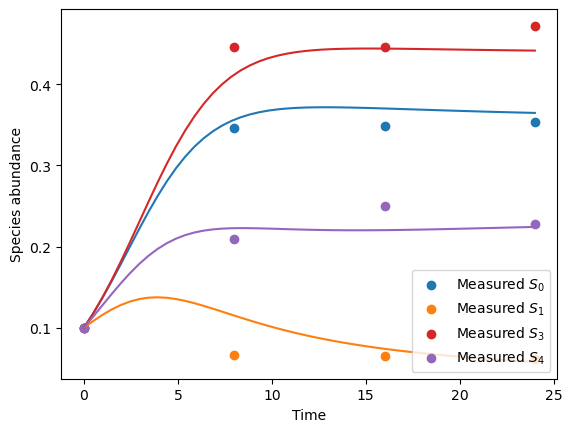

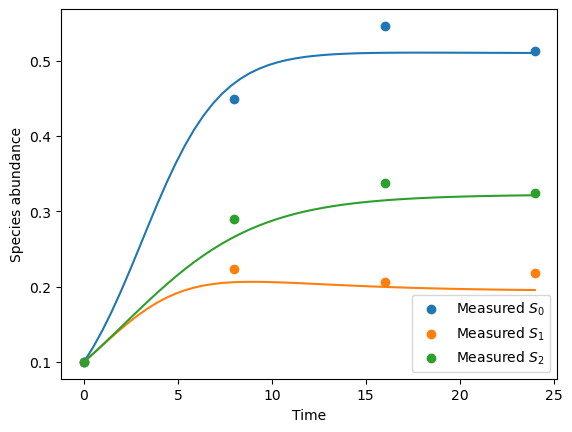

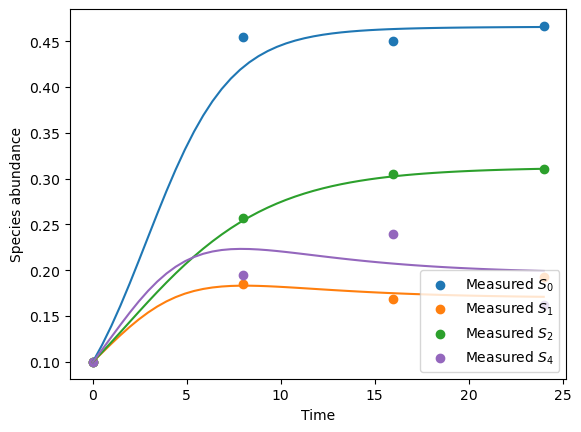

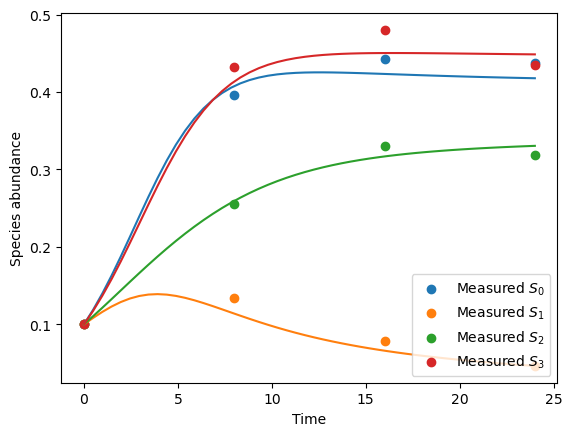

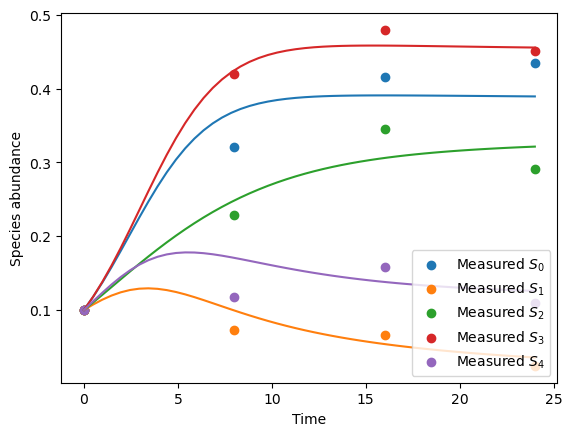

In [3]:
# plot data 
for i in range(len(X))[-10:]:
    
    # integrate ODE
    x = odeint(gLV_gt, X[i][0], np.linspace(t_span[0], t_span[-1]), z_true)

    # plt each species
    for j in range(n_s):
        if X[i][0,j] > 0:
            # plot data
            plt.scatter(t_span, X[i][:,j], c=f'C{j}', label=f"Measured $S_{j}$")
            plt.plot(np.linspace(t_span[0], t_span[-1]), x[:,j], c=f'C{j}')
    plt.legend(loc='lower right')
    plt.ylabel("Species abundance")
    plt.xlabel("Time")
    plt.show()

In [4]:
# generalized Lotka Volterra model (gLV)
@jit
def gLV(x, t, z):
    
    # modify output to make parameters make sense
    r, A = reshape_z(z)

    # make sure growth rates are positive
    r = jnp.exp2(r)/10.

    # make sure self interactions are negative
    for i in range(n_s):
        A = A.at[i,i].set(-jnp.exp2(A[i,i]))
    
    return x * (r + jnp.einsum('ij,j->i', A, x)) * (1. - x)

# define model that takes as input the initial condition the latent variables
@jit
def model(x, z):
    
    # integrate ODE
    t_hat = odeint(gLV, jnp.array(x[0]), t_span, z)
    
    # t_hat is the model estimate of observed variable t
    return t_hat[1:]

# gradient of model w.r.t. latent variables z
grad_model = jit(jacrev(model, 1))

# problem dimension
d = len(z_true)

# number of transformations
k = 16

# total number of parameters 
n_params = k * (2*d + 1)

# initial parameter values of normalizing flow
lmbda = np.random.randn(n_params) / d

# return list [[w1, u1, b1], ..., [wk, uk, bk]]
def reshape(params):
    params_list = []
    for i in range(k):
        params_list.append([params[i*(2*d+1):i*(2*d+1)+d], 
                            params[i*(2*d+1)+d:i*(2*d+1)+2*d], 
                            params[i*(2*d+1)+2*d]])
    return params_list

# jit compile functions used in planar flow model
m_func = jit(lambda x: jnp.log(1. + jnp.exp(x)) - 1.)
h = jit(lambda z, w, b: tanh(jnp.dot(w, z) + b))
psi = jit(grad(h))

@jit
def nn(y, lmbda):
    
    # weights and biases of nn
    for w, u, b in reshape(lmbda):
        # modify u to guarantee invertibility 
        wTu = jnp.dot(w, u)
        wTw = jnp.dot(w, w)
        u += w*(m_func(wTu) - wTu)/wTw
        
        # planar flow transformation
        y += u*h(y, w, b)
    
    return y 

# gradient of nn w.r.t. variational parameters lmbda
grad_nn = jit(jacfwd(nn, 1))

# batch eval of nn
batch_nn = jit(vmap(nn, (0, None)))

@jit
def log_det(y, lmbda):
    
    # weights and biases of nn
    log_det_val = 0.
    for w, u, b in reshape(lmbda):
        # modify u to guarantee invertibility 
        wTu = jnp.dot(w, u)
        wTw = jnp.dot(w, w)
        u += w*(m_func(wTu) - wTu)/wTw
        
        # compute log det
        log_det_val += jnp.log(jnp.abs(1. + jnp.dot(u, psi(y, w, b))))
        
        # update y
        y += u*h(y, w, b)
    
    return log_det_val

# evaluate log_det in batches
batch_log_det = jit(vmap(log_det, (0, None)))

# gradient of log abs det w.r.t. neural network parameters
grad_log_det = jit(jacrev(log_det, 1))

# gradient of entropy of approximating distribution w.r.t. lmbda
batch_grad_log_det = jit(jacrev(batch_log_det, 1))

# precision of Gaussian prior over z
alpha = .1

# set prior parameter mean on transformed variables
r_prior = np.log2(3.*np.ones(n_s))
A_prior = np.zeros([n_s, n_s])
for i in range(n_s):
    # self interaction
    A_prior[i, i] = np.log2(1.)
z_prior = jnp.append(r_prior, A_prior.flatten())

# evaluate log prior
@jit
def log_prior(y, lmbda):
    # map to sample from posterior
    z = nn(y, lmbda)
    
    # prior
    lp = alpha * jnp.sum((z-z_prior)**2) / 2.
    
    return lp

# eval log posterior in batches 
batch_log_prior = jit(vmap(log_prior, (0, None)))

# gradient of log posterior
grad_log_prior = jit(jacrev(log_prior, 1))

# gradient of log posterior
batch_grad_log_prior = jit(jacrev(batch_log_prior, 1))

# evaluate log likelihood 
@jit
def log_likelihood(y, x, lmbda):
    # map to sample from posterior
    z = nn(y, lmbda)
    # likelihood
    lp = beta * jnp.sum((x[1:] - model(x, z))**2) / 2. 
    
    return lp

# eval log posterior in batches 
batch_log_likelihood = jit(vmap(log_likelihood, (0, None, None)))

# gradient of log posterior w.r.t. variational parameters lmbda
grad_log_likelihood = jit(jacrev(log_likelihood, 2))

# batch evaluation of gradient of log posterior
batch_grad_log_likelihood = jit(jacrev(batch_log_likelihood, 2))

# slower but potentially more numerically stable gradient 
def grad_log_likelihood_slow(y, x, lmbda):
    # map to sample from posterior
    z = nn(y, lmbda)
    return beta * jnp.einsum('tk,tki,ij->j', model(x, z) - x[1:], grad_model(x, z), grad_nn(y, lmbda))

print(f"number of parameters in nn: {n_params}")

number of parameters in nn: 2562


In [5]:
# ELBO cost function 
def elbo(lmbda, n_sample=10):
    
    # use nn to sample parameters
    y = np.random.randn(n_sample, d)
    
    # evaluate model fitness 
    '''ELBO = np.nanmean(batch_log_prior(y, lmbda), 0)
    for x in X:
        ELBO += np.nanmean(batch_log_likelihood(y, x, lmbda), 0)
    ELBO -= np.nanmean(batch_log_det(y, lmbda), 0)'''
    
    ELBO = 0.
    for yi in y:
        ELBO += np.nan_to_num(log_prior(yi, lmbda)) / n_sample
        for x in X:
            ELBO += np.nan_to_num(log_likelihood(yi, x, lmbda)) / n_sample
        ELBO -= np.nan_to_num(log_det(yi, lmbda)) / n_sample
    
    return ELBO

# gradient of ELBO cost function
def grad_elbo(lmbda, n_sample=10):
    
    # use nn to sample parameters
    y = np.random.randn(n_sample, d)
    
    # gradient 
    '''grad_ELBO = np.nanmean(batch_grad_log_prior(y, lmbda), 0)
    for x in X:
        grad_ELBO += np.nanmean(batch_grad_log_likelihood(y, x, lmbda), 0)
    grad_ELBO -= np.nanmean(batch_grad_log_det(y, lmbda), 0)'''
    
    grad_ELBO = 0.
    for yi in y:
        grad_ELBO += np.nan_to_num(grad_log_prior(yi, lmbda)) / n_sample
        for x in X:
            grad_ELBO += np.nan_to_num(grad_log_likelihood(yi, x, lmbda)) / n_sample
        grad_ELBO -= np.nan_to_num(grad_log_det(yi, lmbda)) / n_sample
    
    return grad_ELBO

In [19]:
# adam from chat gpt
def adam_optimizer(f, grad_f, initial_params, 
                   learning_rate=1e-3, beta1=0.9, beta2=0.999, epsilon=1e-8, 
                   max_iterations=1000, tol=1e-6):
    """
    ADAM optimizer for minimizing a function.

    Parameters:
    - grad_f: Gradient function that returns the gradient of the objective function.
    - initial_params: Initial guess for the parameters.
    - learning_rate: Step size for the optimization (default: 0.001).
    - beta1: Exponential decay rate for the first moment estimate (default: 0.9).
    - beta2: Exponential decay rate for the second moment estimate (default: 0.999).
    - epsilon: Small constant to prevent division by zero (default: 1e-8).
    - max_iterations: Maximum number of iterations (default: 1000).
    - tol: Tolerance to stop optimization when the change in parameters is below this value (default: 1e-6).

    Returns:
    - Optimal parameters.
    """
    params = initial_params
    m = np.zeros_like(params)
    v = np.zeros_like(params)
    t = 0

    while t < max_iterations:
        t += 1
        print("ELBO: {:.3f}".format(elbo(params)))
        
        gradient = grad_f(params)
        
        m = beta1 * m + (1 - beta1) * gradient
        v = beta2 * v + (1 - beta2) * (gradient ** 2)

        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)

        params -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

        if np.linalg.norm(learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)) < tol:
            break

    return params

In [20]:
# optimize nn parameters
lmbda = adam_optimizer(elbo, grad_elbo, lmbda, learning_rate=1e-2)

ELBO: 27299.007


/tmp/ipykernel_23497/1155600690.py:33: RuntimeWarning: overflow encountered in square
  v = beta2 * v + (1 - beta2) * (gradient ** 2)


ELBO: 29370.232
ELBO: 27241.276
ELBO: 30302.580
ELBO: 28041.602
ELBO: 24453.050
ELBO: 29140.250
ELBO: 28474.275
ELBO: 28098.625
ELBO: 26404.852
ELBO: 32606.086
ELBO: 27682.935
ELBO: 31601.921
ELBO: 30032.152
ELBO: 31888.252
ELBO: 31801.521
ELBO: 26889.872
ELBO: 25947.558
ELBO: 28393.916
ELBO: 25614.260
ELBO: 29801.161
ELBO: 33859.397
ELBO: 27952.727
ELBO: 25416.232
ELBO: 30148.652
ELBO: 30903.743
ELBO: 29384.486
ELBO: 37166.848
ELBO: 32840.797
ELBO: 26352.643
ELBO: 31266.366
ELBO: 25718.064
ELBO: 34682.823
ELBO: 28207.265
ELBO: 30736.860
ELBO: 29463.518
ELBO: 25419.024
ELBO: 24881.092
ELBO: 26428.314
ELBO: 31724.605
ELBO: 25558.531
ELBO: 28119.172
ELBO: 30884.451
ELBO: 27246.335
ELBO: 30114.124
ELBO: 35763.350
ELBO: 30972.282
ELBO: 25638.238
ELBO: 29086.035
ELBO: 29094.294
ELBO: 30883.773
ELBO: 31356.249
ELBO: 32901.118
ELBO: 29842.998
ELBO: 36710.023
ELBO: 28834.727
ELBO: 30126.972
ELBO: 31332.470
ELBO: 29910.826
ELBO: 29982.936
ELBO: 24210.378
ELBO: 31153.732
ELBO: 34731.908
ELBO: 27

In [10]:
# sample noise
# y = np.random.random(size=[1000, d])
y = np.random.randn(2000, d)
z = batch_nn(y, lmbda)

In [11]:
# transform to correct z vale
def z_transform(z):
    # modify output to make parameters make sense
    r, A = reshape_z(z)

    # make sure growth rates are positive
    r = jnp.exp2(r)/10.

    # make sure self interactions are negative
    for i in range(n_s):
        A = A.at[i,i].set(-jnp.exp2(A[i,i]))
        
    return jnp.append(r, A.flatten())

batch_z_transform = jit(vmap(z_transform))
z = batch_z_transform(z)

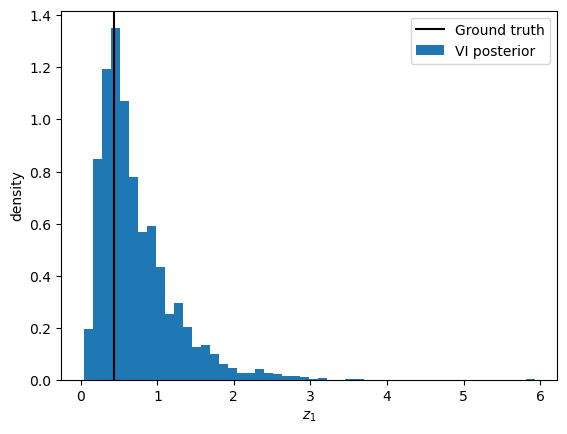

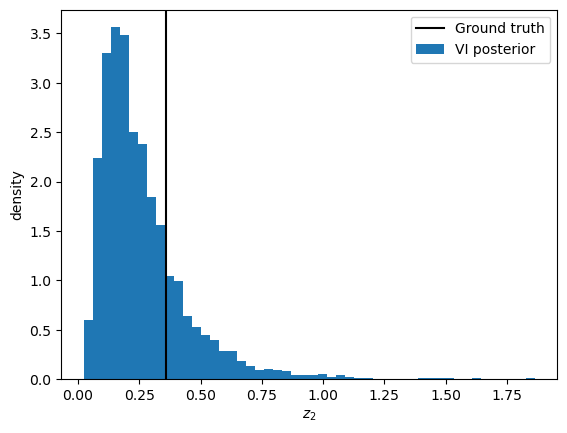

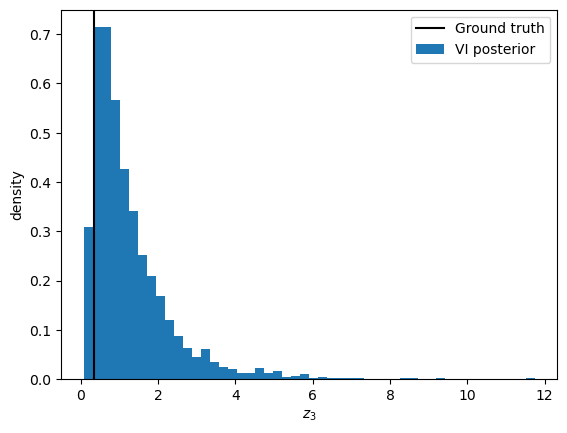

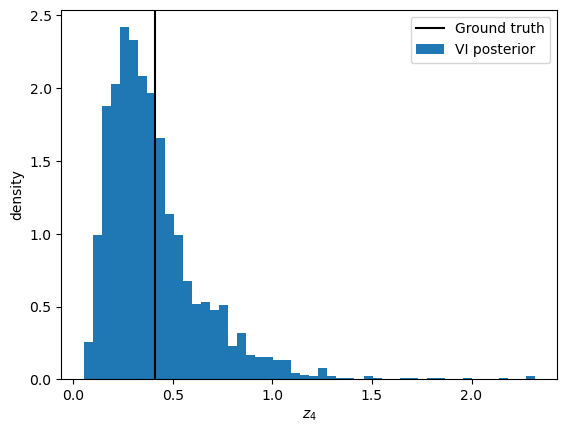

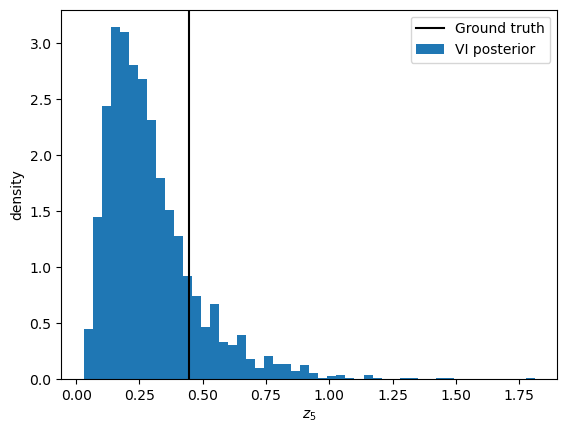

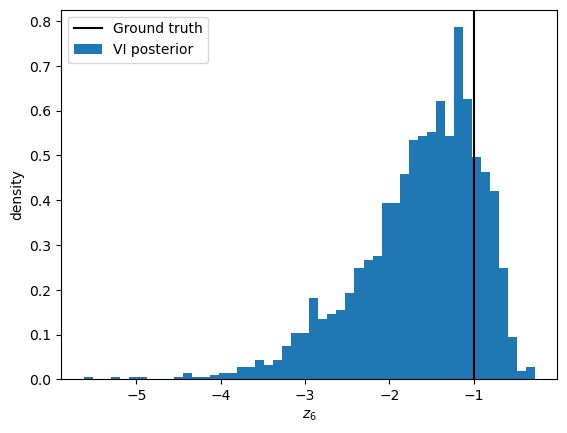

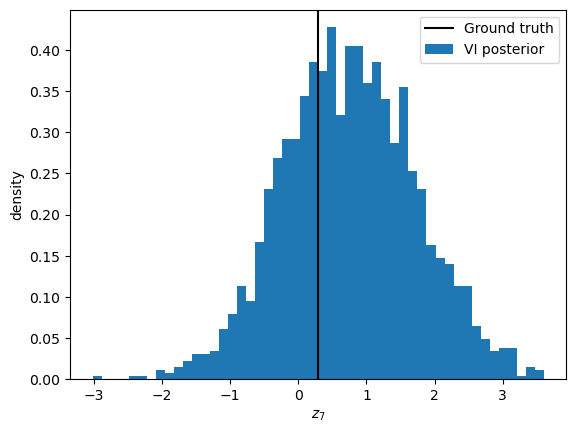

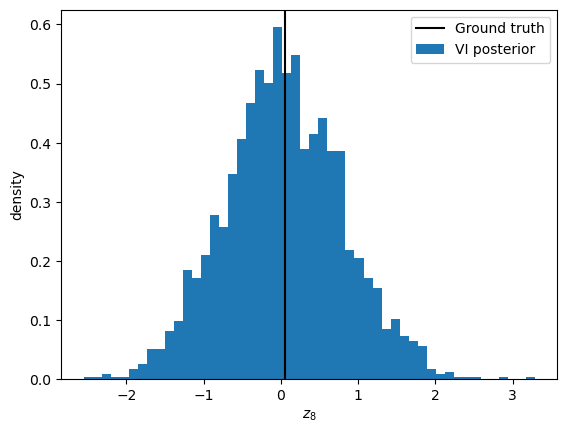

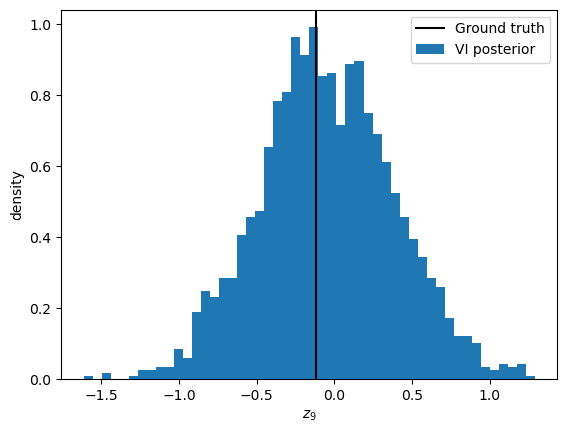

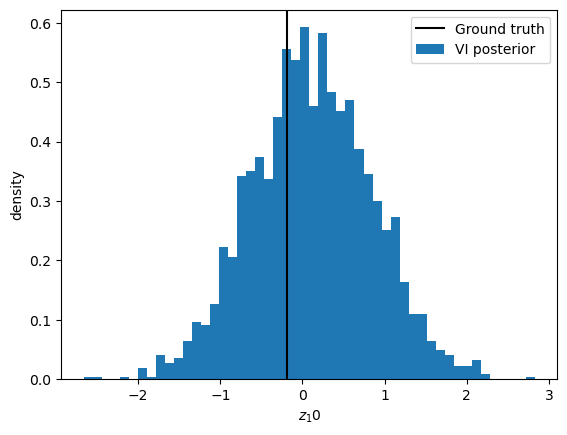

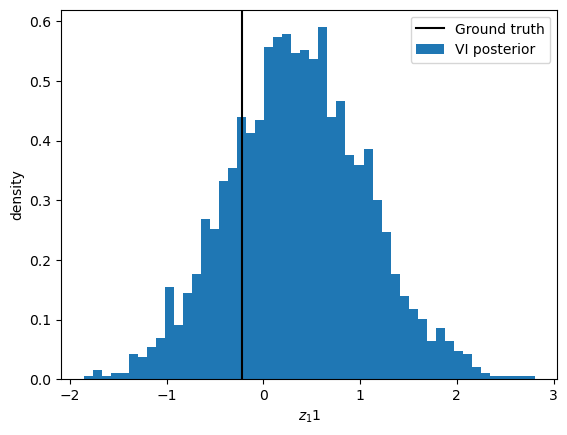

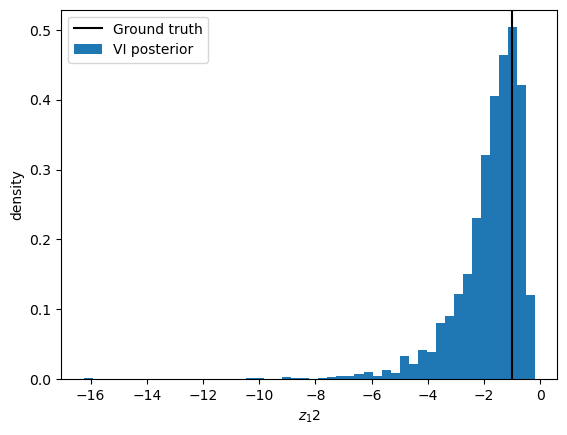

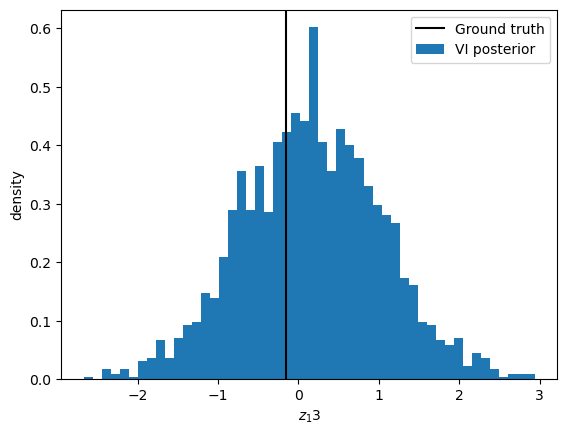

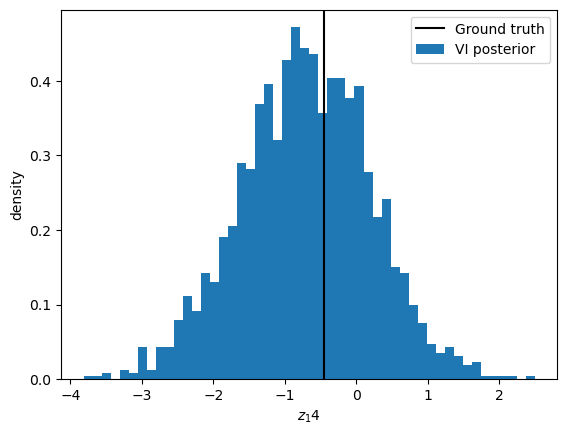

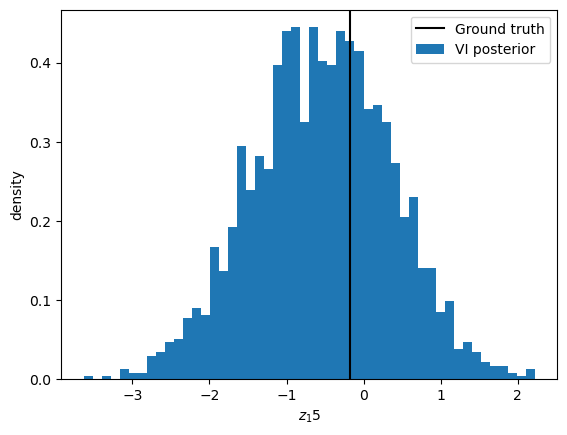

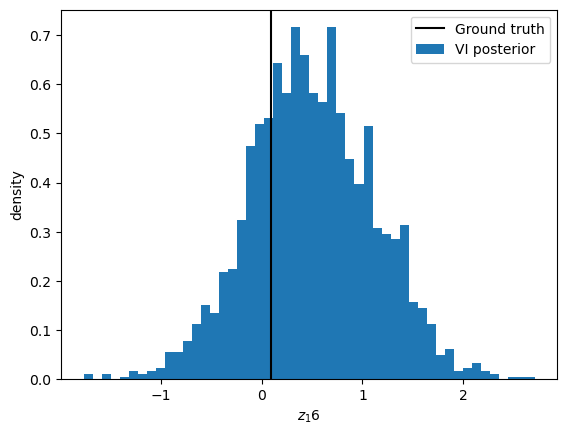

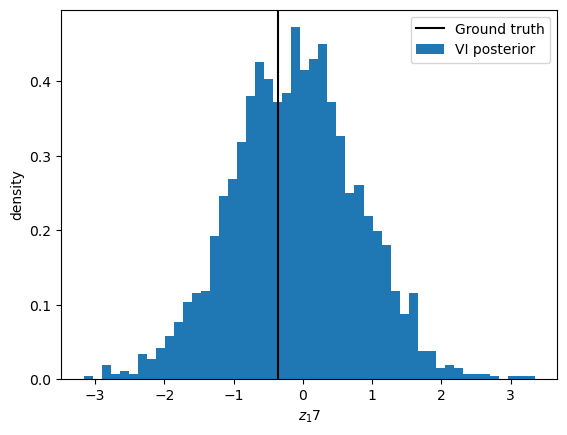

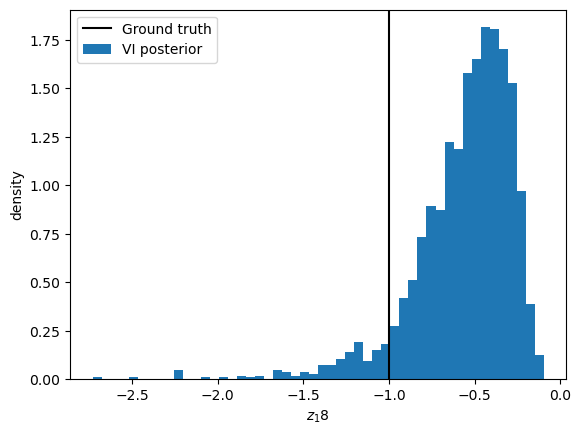

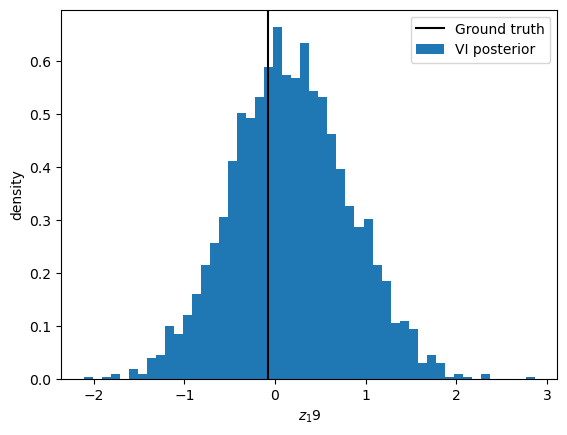

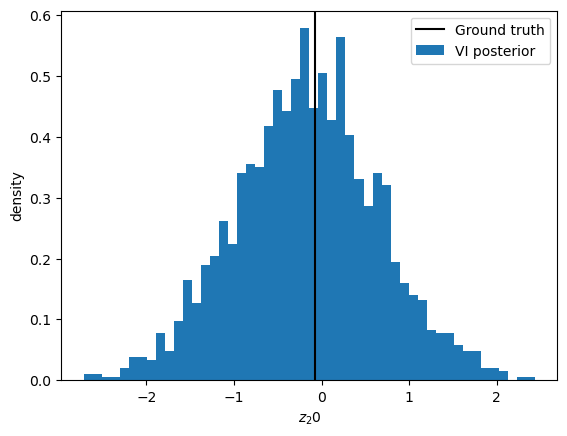

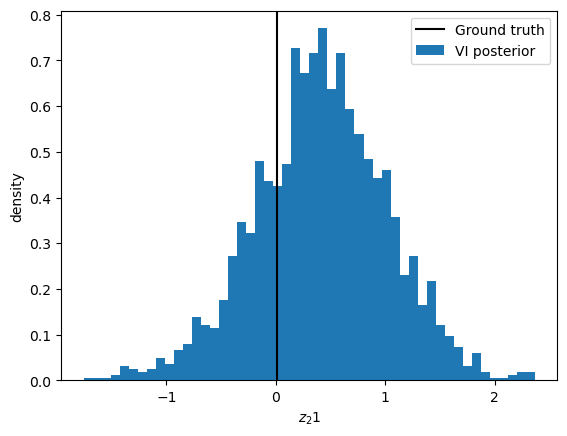

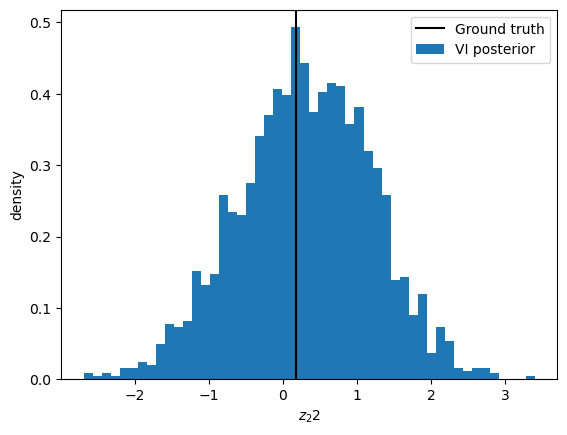

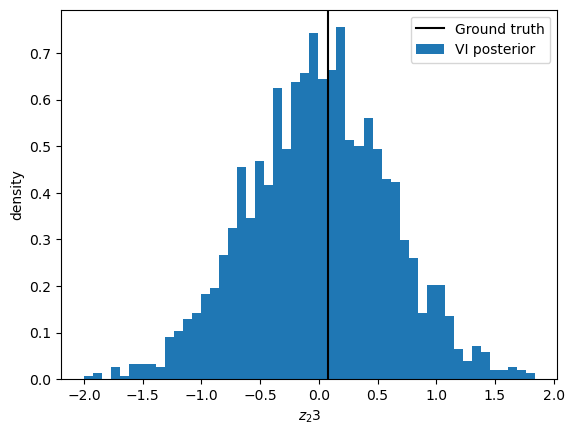

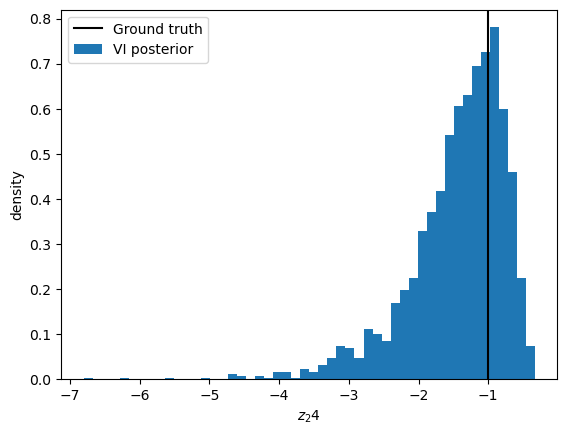

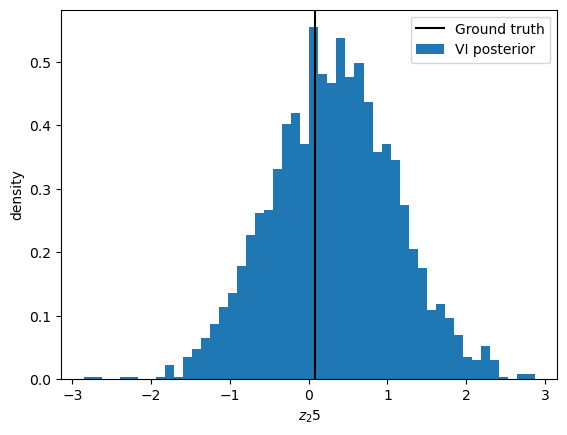

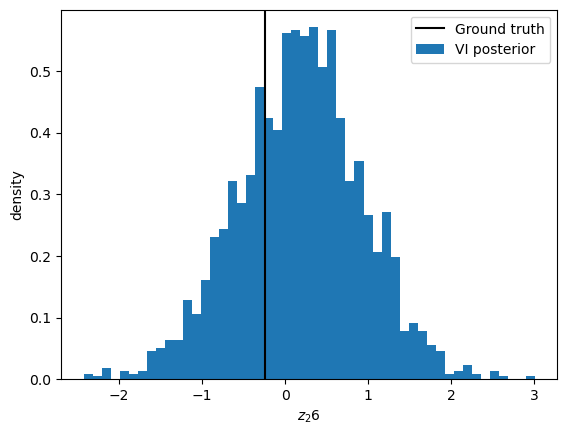

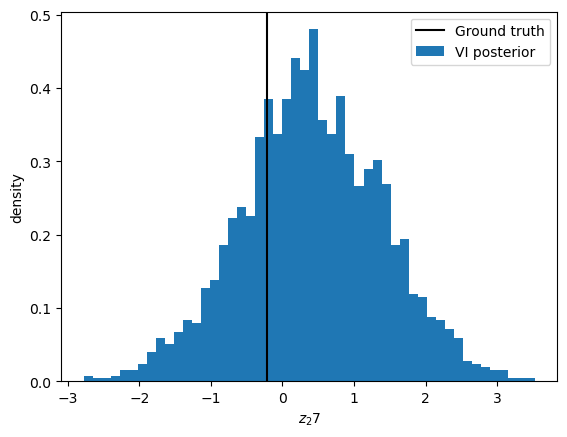

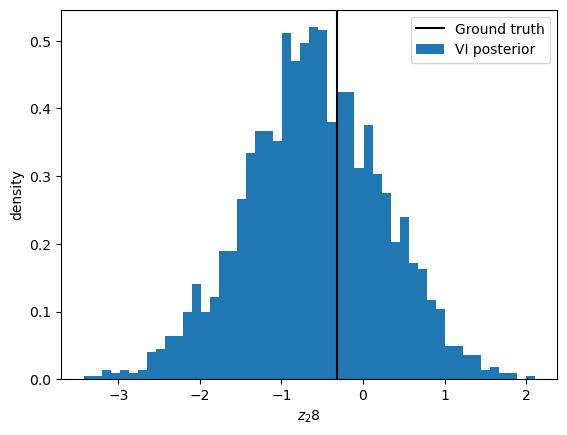

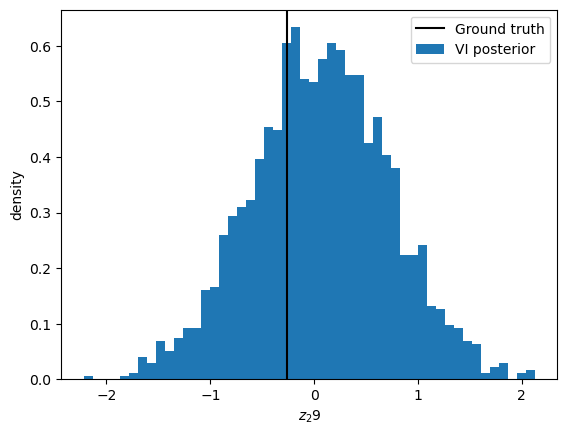

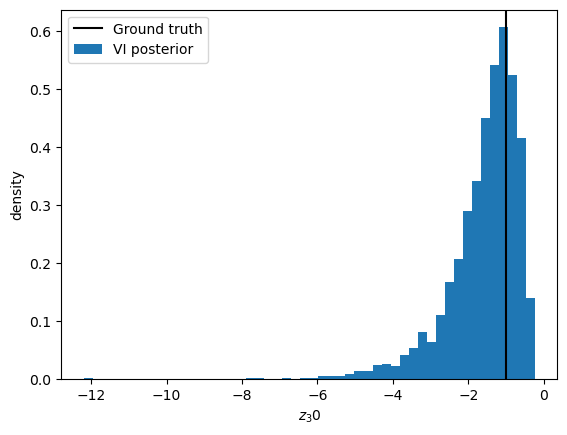

In [12]:
for i, z_true_i in enumerate(z_true):
    
    # plot NN posterior 
    plt.hist(np.array(z[:, i]), color='C0', bins=50, density=True, label='VI posterior')
    plt.axvline(x=z_true_i, c='k', label='Ground truth')
    
    plt.xlabel(f"$z_{i+1}$")
    plt.ylabel("density")
    plt.legend()
    plt.show()

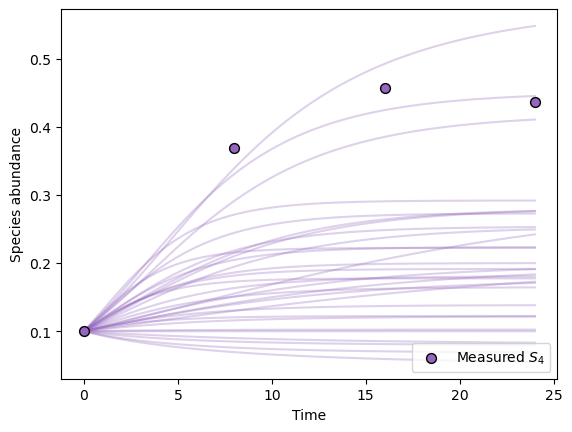

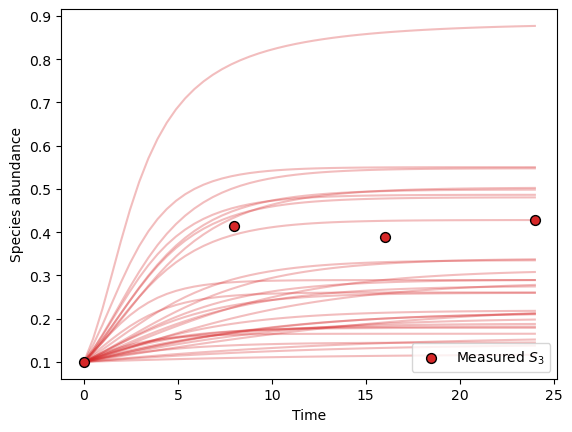

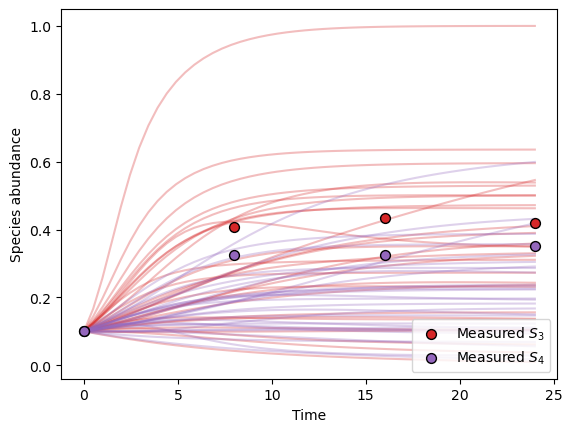

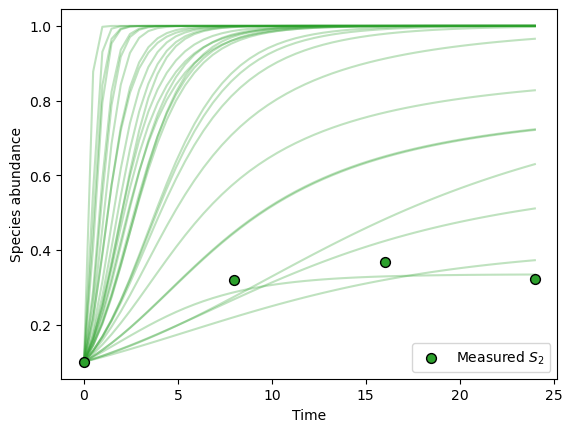

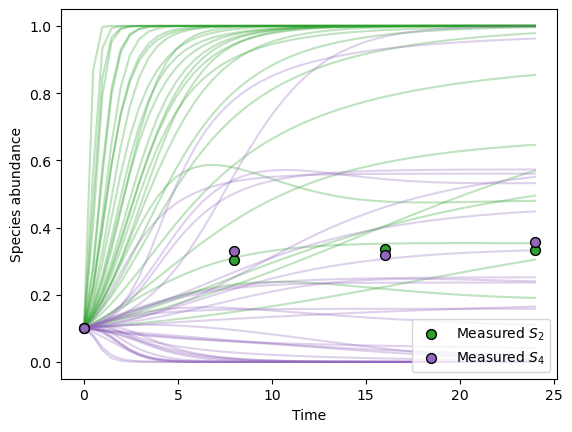

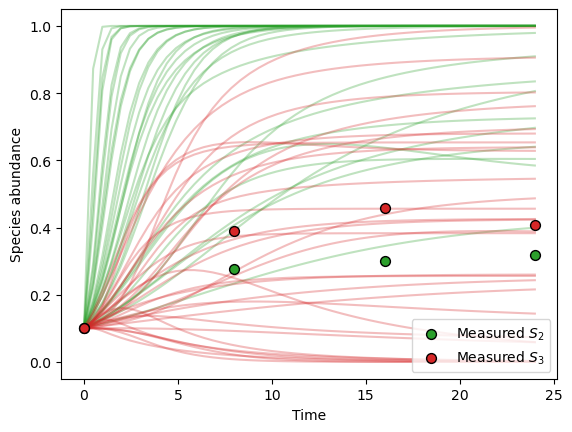

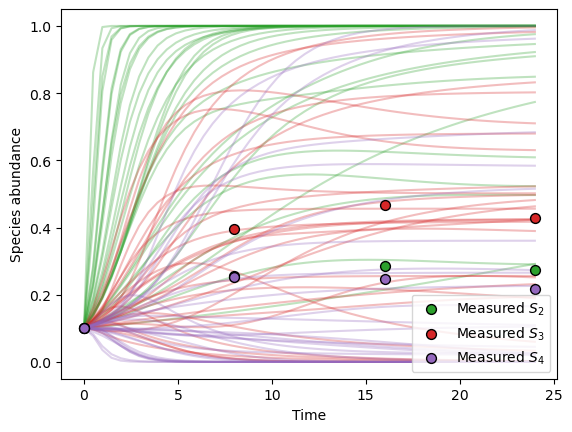

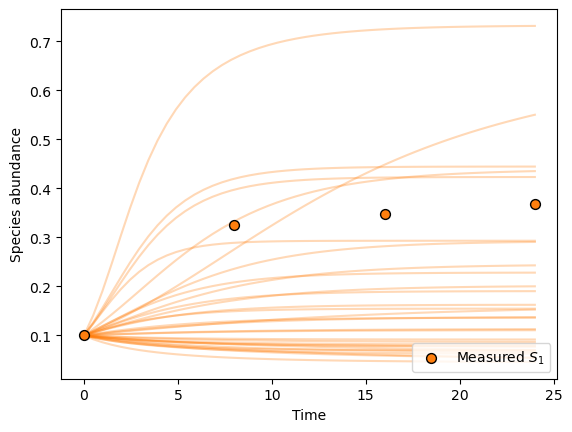

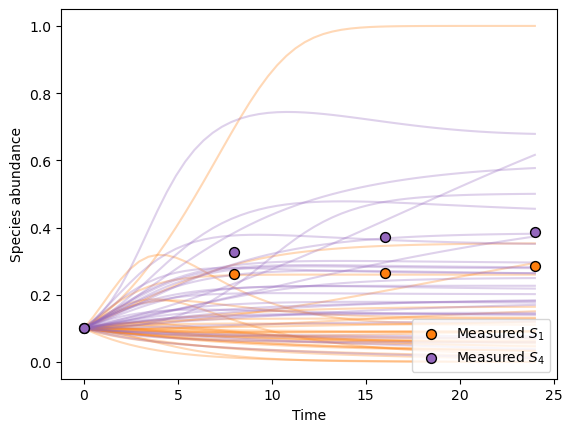

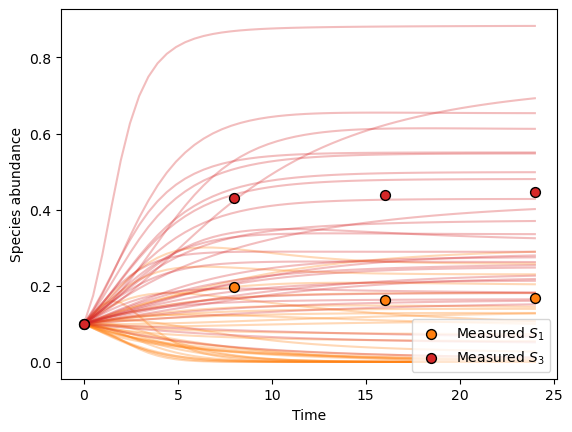

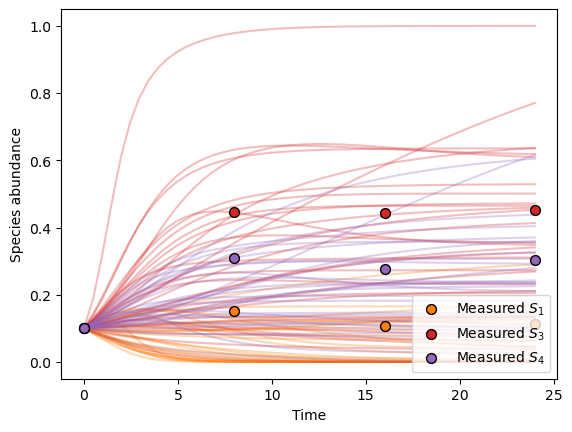

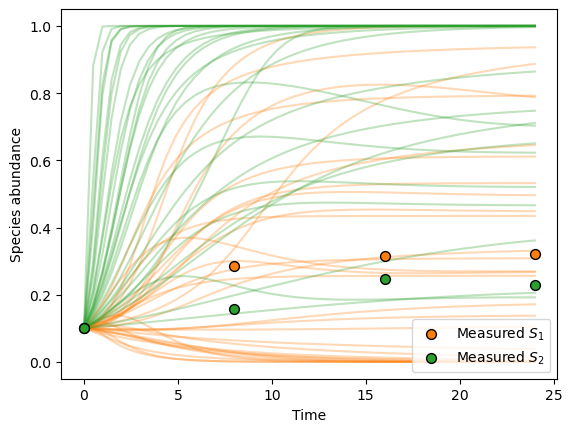

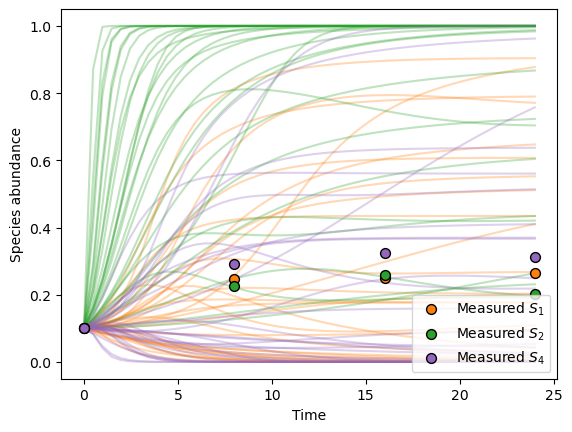

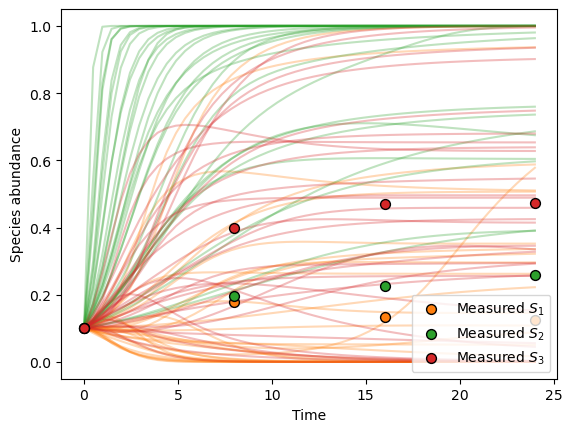

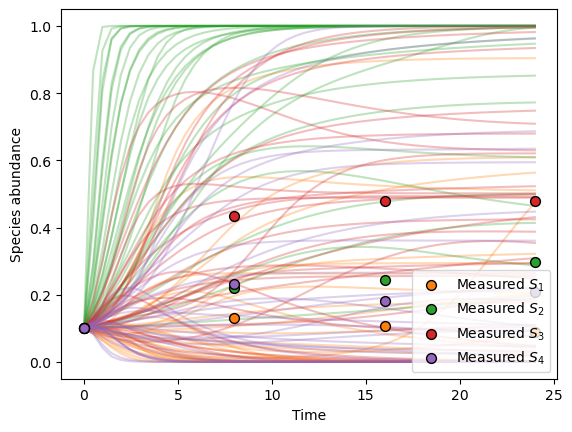

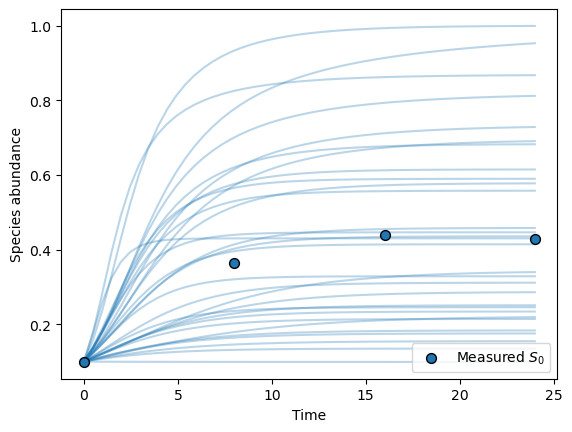

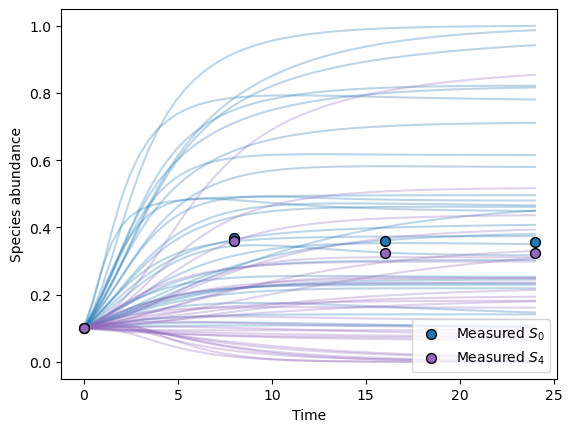

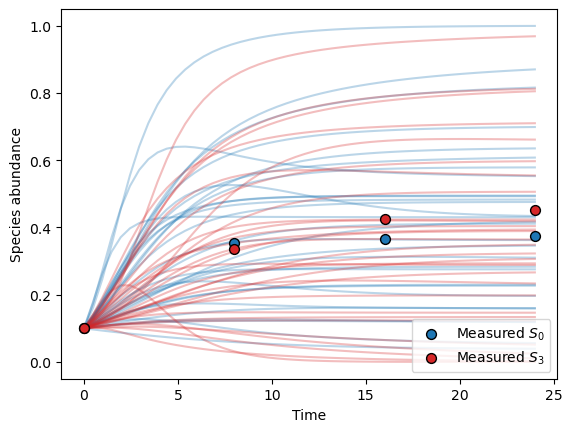

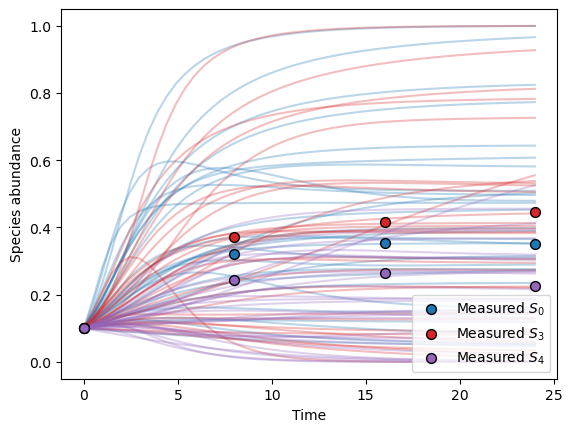

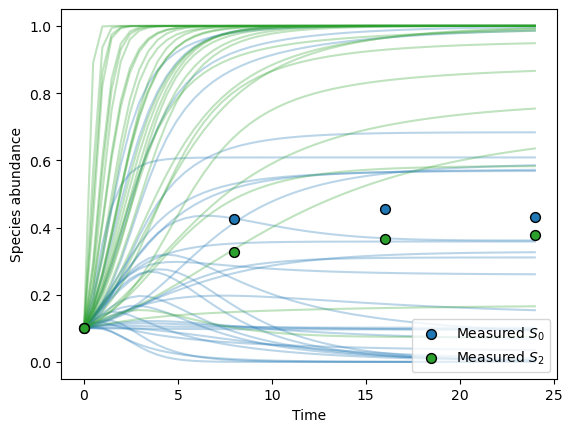

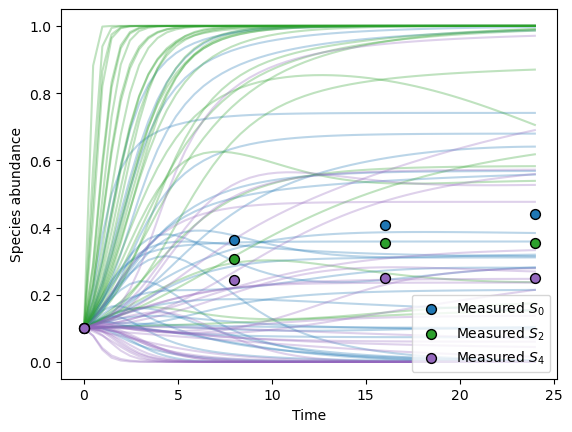

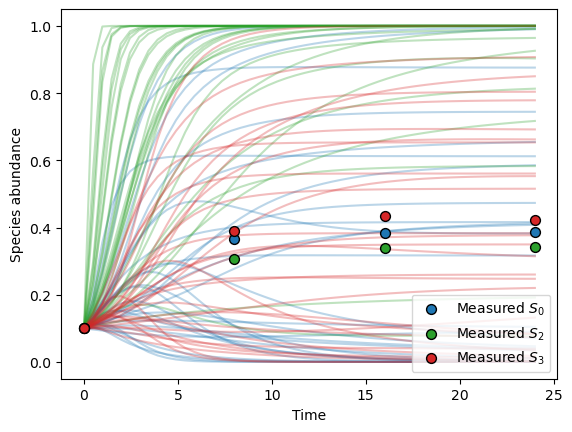

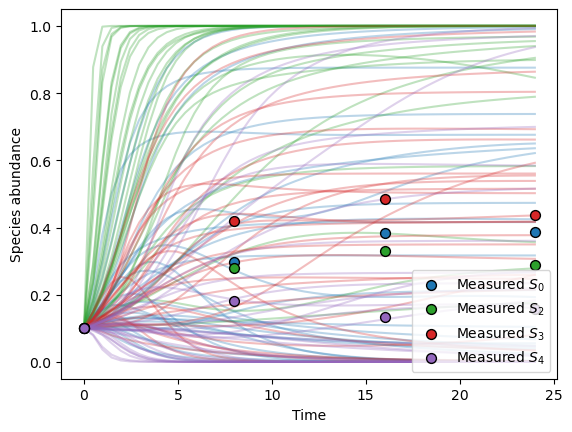

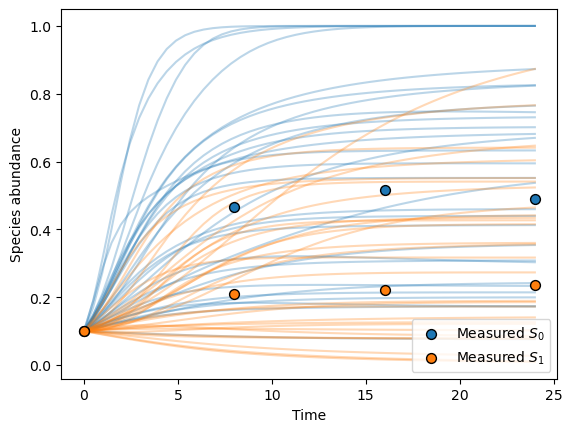

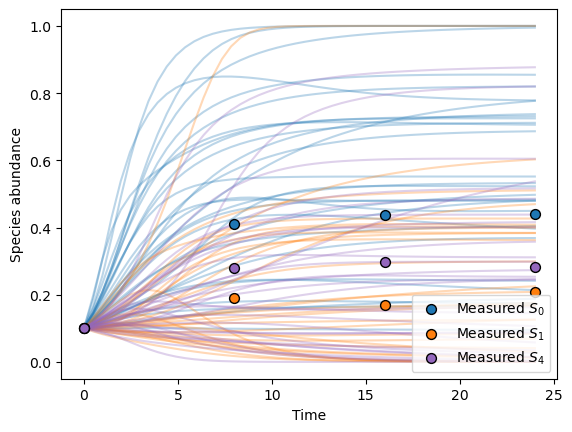

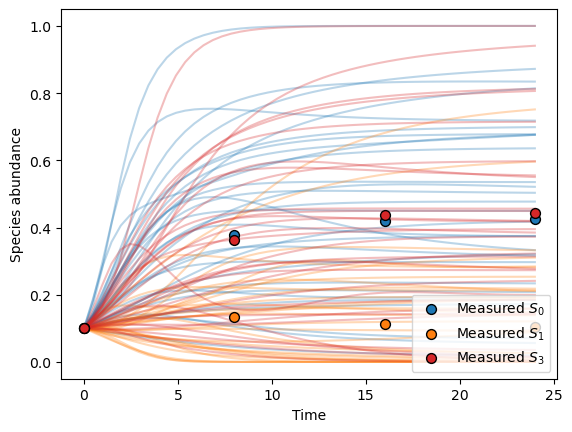

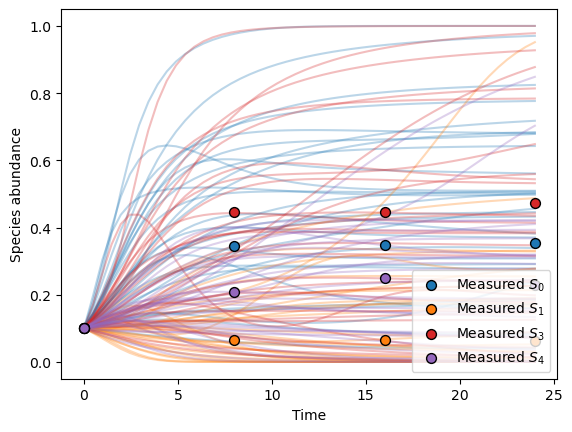

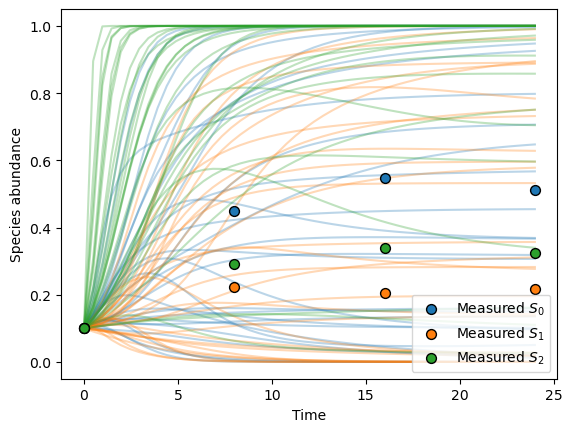

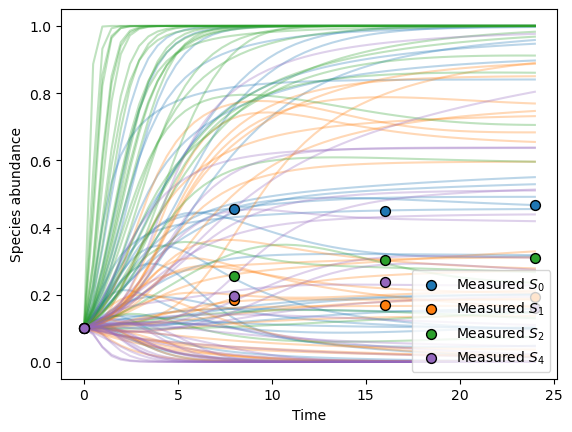

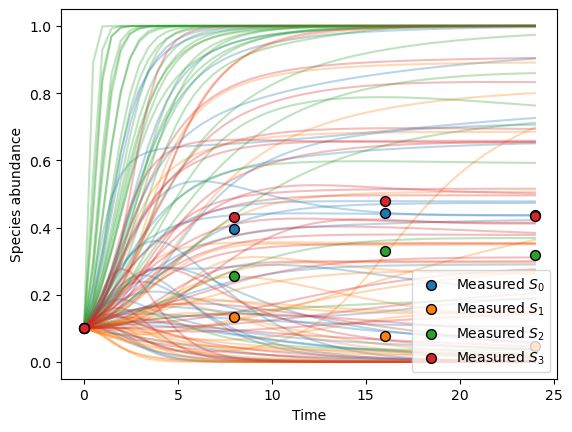

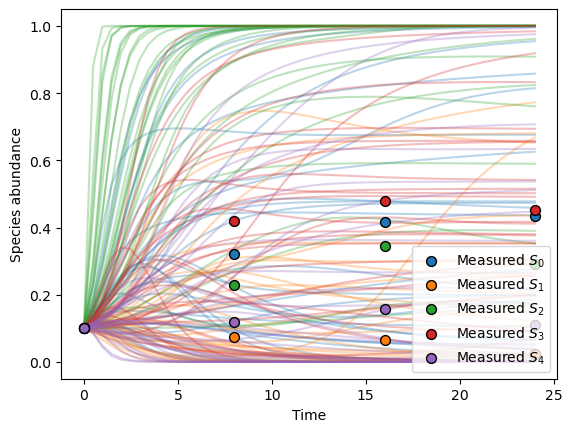

In [13]:
# sample noise
# y = np.random.random(size=[1000, d])
y = np.random.randn(30, d)
z = batch_nn(y, lmbda)

# plot data 
for Xi in X:

    # plt each species
    for j in range(n_s):
        if Xi[0,j] > 0:
            # plot data
            plt.scatter(t_span, Xi[:,j], c=f'C{j}', label=f"Measured $S_{j}$",
                        zorder=1, edgecolor='k', s=50)
            
            # plot samples from posterior
            for z_sample in z:
                x = odeint(gLV, Xi[0], np.linspace(t_span[0], t_span[-1]), z_sample)
                plt.plot(np.linspace(t_span[0], t_span[-1]), x[:,j], c=f'C{j}', alpha=.3, zorder=0)
    plt.legend(loc='lower right')
    plt.ylabel("Species abundance")
    plt.xlabel("Time")
    plt.show()

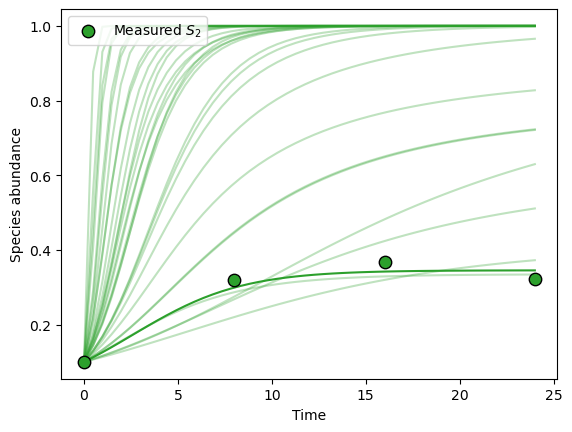

In [14]:
# pick condition
i = 3

# plt each species
for j in range(n_s):
    if X[i][0,j] > 0:
        # plot data
        plt.scatter(t_span, X[i][:,j], c=f'C{j}', label=f"Measured $S_{j}$",
                    zorder=2, edgecolor='k', s=80)

        # ground truth
        x = odeint(gLV_gt, X[i][0], np.linspace(t_span[0], t_span[-1]), z_true)
        plt.plot(np.linspace(t_span[0], t_span[-1]), x[:,j], c=f'C{j}', alpha=1., zorder=1)
        
        # plot samples from posterior
        for z_sample in z:
            x = odeint(gLV, X[i][0], np.linspace(t_span[0], t_span[-1]), z_sample)
            plt.plot(np.linspace(t_span[0], t_span[-1]), x[:,j], c=f'C{j}', alpha=.3, zorder=0)
plt.legend(loc='upper left')
plt.ylabel("Species abundance")
plt.xlabel("Time")
#plt.savefig("figures/gLV_example.png")
plt.show()